In [1]:
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('moniflora-backup-rtdb.csv')

In [3]:
def triangular_membership(value, low, mid, high):
    """Triangular membership function"""
    if value < low or value > high:
        return 0
    elif value < mid:
        return (value - low) / (mid - low)
    else:
        return (high - value) / (high - mid)

In [4]:
def determine_label(value):
    temp = value['temperature']
    light = value['light']
    ec = value['conductivity']
    moisture = value['moisture']

    # Define the fuzzy sets
    temp_optimal = triangular_membership(temp, 20, 25, 30)
    light_optimal = triangular_membership(light, 1500, 4500, 7500)
    ec_optimal = triangular_membership(ec, 950, 2000, 3000)
    moisture_optimal = triangular_membership(moisture, 30, 42.5, 55)

    temp_caution = max(triangular_membership(temp, 18, 20, 22), triangular_membership(temp, 28, 30, 32))
    light_caution = max(triangular_membership(light, 1000, 1500, 2000), triangular_membership(light, 7500, 8000, 8500))
    ec_caution = max(triangular_membership(ec, 800, 950, 1100), triangular_membership(ec, 3000, 3200, 3400))
    moisture_caution = max(triangular_membership(moisture, 25, 30, 35), triangular_membership(moisture, 55, 60, 65))

    # Check if the values are within the optimal or caution ranges
    if (temp_optimal > 0 or temp_caution > 0) and (light_optimal > 0 or light_caution > 0) and (ec_optimal > 0 or ec_caution > 0) and (moisture_optimal > 0 or moisture_caution > 0):
        # Check if the values are within the optimal ranges
        if temp_optimal > 0 and light_optimal > 0 and ec_optimal > 0 and moisture_optimal > 0:
            return 0  # Optimal
        else:
            return 1  # Caution
    elif temp < 20 or light < 600 or ec < 500 or moisture < 25:
        return 2
    else:
        return 2  # Extreme

In [5]:
def prepare_data(dataset):
    data = {
        'temperature': [],
        'light': [],
        'conductivity': [],
        'moisture': [],
        'label': []
    }

    for index, value in dataset.iterrows():
        data['temperature'].append(value['temperature'])
        data['light'].append(value['light'])
        data['conductivity'].append(value['conductivity'])
        data['moisture'].append(value['moisture'])
        data['label'].append(determine_label(value))

    return pd.DataFrame(data)



In [6]:
# Filter the sample to only use latest 2000 data with light intensity more than 600 lux
filtered = df[df['light'] >= 600].tail(2000)
data = prepare_data(filtered)

In [7]:
label_counts = Counter(data['label'])
label_names = {0: 'Optimal', 1: 'Caution', 2: 'Extreme'}

for label, count in label_counts.items():
    print(f'{label_names[label]}: {count} datasets')

Optimal: 235 datasets
Caution: 369 datasets
Extreme: 495 datasets


In [8]:
data.isna().sum()

temperature     0
light           0
conductivity    0
moisture        0
label           0
dtype: int64

In [9]:
def parameter_corr(dataset):
    dataset = dataset.drop(columns=['label'])
    correlation_matrix = dataset.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

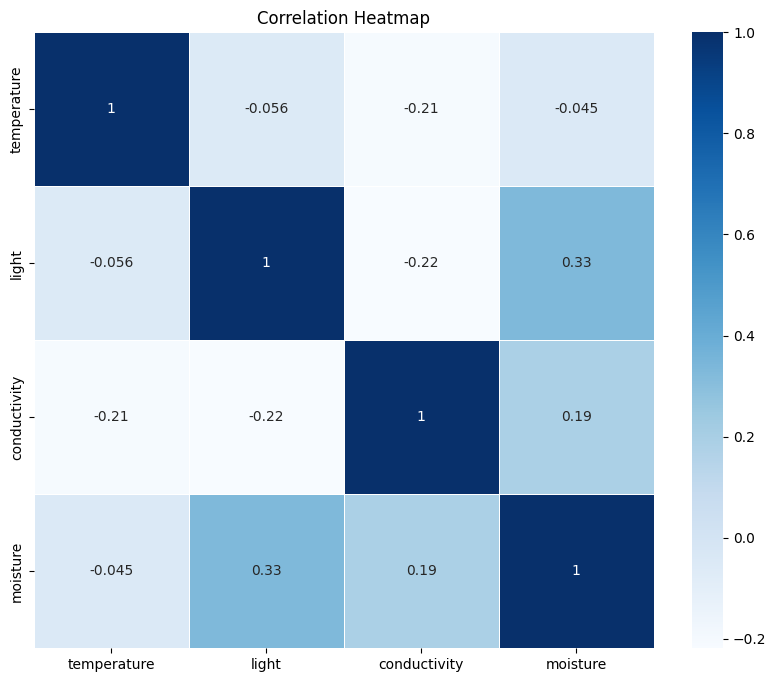

In [10]:
parameter_corr(data)

In [11]:
X = np.array([data['temperature'], data['light'], data['conductivity'], data['moisture']]).T
y = np.array(data['label'])

In [12]:
# 35% Test, 65% Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=13, stratify=y)

In [13]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [15]:
def train_rf(X_train, y_train):
    param_grid = {
        'min_samples_split': [2, 4, 5],
        'min_samples_leaf': [1, 2, 4],
#         'n_estimators': [45, 50, 55, 60] 
    }
        
    grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    forest = RandomForestClassifier(max_depth=5, max_features='log2', **grid_search.best_params_, n_estimators=55, oob_score=True)
    forest.fit(X_train, y_train)
    print('Best parameters:', best_params)
        
    return forest

In [16]:
model = train_rf(X_train_scaled, y_train_balanced)

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}


In [18]:
stratified_kfold = StratifiedKFold(n_splits=5)


In [19]:
score = model.score(X_test_scaled, y_test)
validator = cross_val_score(model, X_test_scaled, y_test, cv=stratified_kfold)

print(f'Random Forest Score: {score}')
print(f'Cross Validation Score: {validator}')

Random Forest Score: 0.9766233766233766
Cross Validation Score: [0.96103896 0.94805195 0.97402597 0.96103896 0.94805195]


In [20]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        82
           1       0.98      0.95      0.96       129
           2       0.98      0.99      0.99       174

    accuracy                           0.98       385
   macro avg       0.98      0.97      0.98       385
weighted avg       0.98      0.98      0.98       385



In [21]:
example_value = {
    "temperature": 26.1,
    "light": 3712,
    "conductivity": 2812,
    "moisture": 32
}

In [22]:
example_features = np.array([[example_value['temperature'], example_value['light'], example_value['conductivity'], example_value['moisture']]])
example_scaled = scaler.transform(example_features)
example_prediction = model.predict(example_scaled)

In [23]:
model.predict_proba(example_scaled)

array([[0.8369729 , 0.08427805, 0.07874905]])

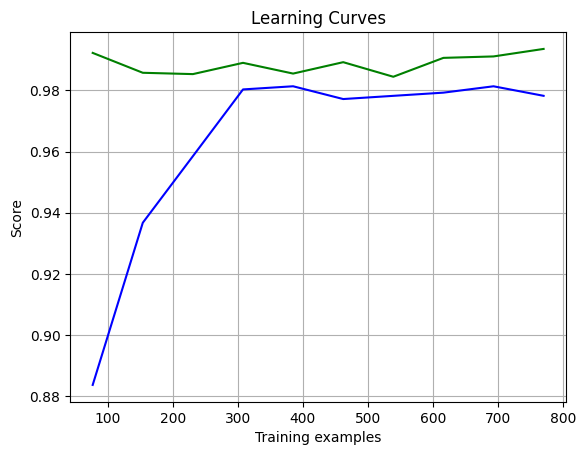

In [24]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train_balanced, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score', color='g')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='b')
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.show()

In [26]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']